In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),               
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# 定义测试数据的预处理
test_transform = transforms.Compose([
    transforms.Resize(256),              
    transforms.CenterCrop(224),          
    transforms.ToTensor(),               
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=False, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=False, transform=test_transform)


/home/nvidia/anaconda3/envs/agcl/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import copy
model = models.resnet18(pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True
initial_state = copy.deepcopy(model.state_dict())
model=model.to(device)

In [4]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
def train(model,train_dataset,val_dataset,batch_size=32,layer4_lr=0.0001,fc_lr=0.0001,epoch=100):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([
    {'params': model.layer4.parameters(), 'lr': layer4_lr},
    {'params': model.fc.parameters(), 'lr': fc_lr}
])
    train_dataloader=DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=4)
    val_dataloader=DataLoader(val_dataset,batch_size=batch_size,shuffle=False,num_workers=4)
    losses=[]
    val_losses=[]
    train_acces=[]
    val_acces=[]
    best_acc=0
    best_epoch=0
    for i in range(epoch):
        model.train()
        running_loss = 0
        running_correct = 0
        total_train = 0
        for batch in train_dataloader:
            img,label=batch
            optimizer.zero_grad()
            img=img.to(device)
            label=label.to(device)
            output=model(img)
            train_loss=criterion(output,label)
            train_loss.backward()
            optimizer.step()
            running_loss += train_loss.item() * img.size(0)
            _, predicted = torch.max(output, 1)
            running_correct += (predicted == label).sum().item()
            total_train += label.size(0)
            train_loss = running_loss / total_train
        train_acc = running_correct / total_train
        losses.append(train_loss)
        train_acces.append(train_acc)
        model.eval()
        val_loss = 0
        correct = 0
        total_val = 0
        with torch.no_grad():
            for batch in val_dataloader:
                img, label = batch
                img = img.to(device)
                label = label.to(device)
                output = model(img)
                loss = criterion(output, label)
                val_loss += loss.item() * img.size(0)
                _, predicted = torch.max(output, 1)
                correct += (predicted == label).sum().item()
                total_val += label.size(0)
        val_epoch_loss = val_loss / total_val
        val_losses.append(val_epoch_loss)
        val_epoch_acc = correct / total_val
        val_acces.append(val_epoch_acc)
        print(f'Epoch [{i+1}/{epoch}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_epoch = i
            best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Best epoch: {best_epoch+1} with accuracy: {best_acc:.4f}')
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Loss over Epochs')
    plt.plot(losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
            
    plt.subplot(1, 2, 2)
    plt.title('Accuracy over Epochs')
    plt.plot(train_acces, label='Train Accuracy')
    plt.plot(val_acces, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    model.load_state_dict(best_model_wts)
    return best_acc

Epoch [1/200], Train Loss: 3.5691, Train Acc: 0.1985, Val Loss: 2.3028, Val Acc: 0.4295
Epoch [2/200], Train Loss: 2.6180, Train Acc: 0.3597, Val Loss: 1.7545, Val Acc: 0.5275
Epoch [3/200], Train Loss: 2.3272, Train Acc: 0.4114, Val Loss: 1.5285, Val Acc: 0.5744
Epoch [4/200], Train Loss: 2.1717, Train Acc: 0.4420, Val Loss: 1.4040, Val Acc: 0.6053
Epoch [5/200], Train Loss: 2.0629, Train Acc: 0.4676, Val Loss: 1.3242, Val Acc: 0.6227
Epoch [6/200], Train Loss: 1.9870, Train Acc: 0.4816, Val Loss: 1.2771, Val Acc: 0.6398
Epoch [7/200], Train Loss: 1.9378, Train Acc: 0.4925, Val Loss: 1.2248, Val Acc: 0.6421
Epoch [8/200], Train Loss: 1.8960, Train Acc: 0.5017, Val Loss: 1.1859, Val Acc: 0.6571
Epoch [9/200], Train Loss: 1.8484, Train Acc: 0.5118, Val Loss: 1.1609, Val Acc: 0.6627
Epoch [10/200], Train Loss: 1.7987, Train Acc: 0.5255, Val Loss: 1.1318, Val Acc: 0.6702
Epoch [11/200], Train Loss: 1.7668, Train Acc: 0.5299, Val Loss: 1.1135, Val Acc: 0.6785
Epoch [12/200], Train Loss: 1.

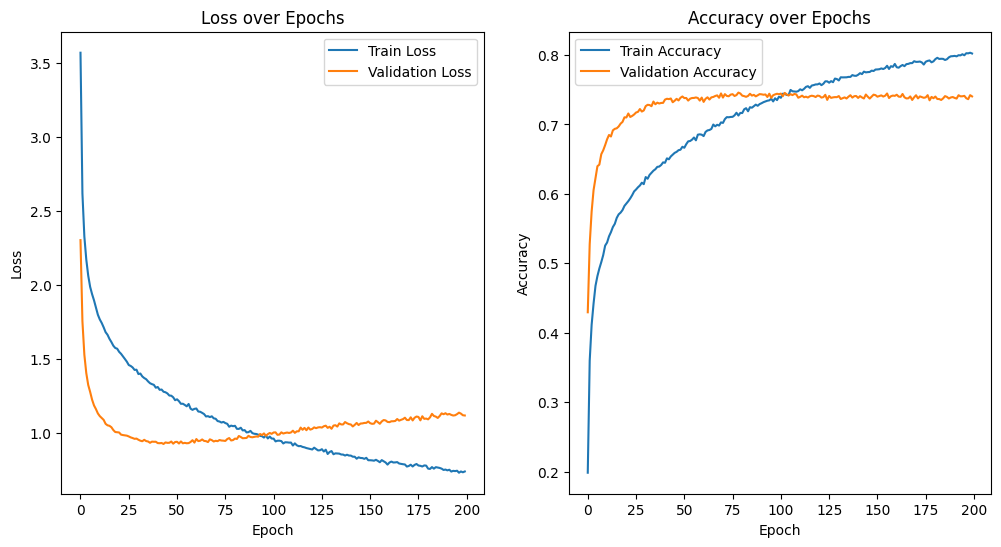

In [5]:
train(model,train_dataset,test_dataset,batch_size=32,layer4_lr=0.00001,fc_lr=0.0001,epoch=200)
torch.save(model.state_dict(),'resnet18_pretrained_model_weights_pre.pth')

Training with batch_size=32, lr_layer4=0.0001,lr_fc=0.001
Epoch [1/100], Train Loss: 2.6216, Train Acc: 0.3440, Val Loss: 1.4804, Val Acc: 0.5778
Epoch [2/100], Train Loss: 2.0891, Train Acc: 0.4544, Val Loss: 1.3420, Val Acc: 0.6263
Epoch [3/100], Train Loss: 1.9314, Train Acc: 0.4932, Val Loss: 1.3017, Val Acc: 0.6343
Epoch [4/100], Train Loss: 1.8412, Train Acc: 0.5158, Val Loss: 1.2043, Val Acc: 0.6676
Epoch [5/100], Train Loss: 1.7580, Train Acc: 0.5351, Val Loss: 1.2452, Val Acc: 0.6571
Epoch [6/100], Train Loss: 1.7007, Train Acc: 0.5490, Val Loss: 1.2480, Val Acc: 0.6681
Epoch [7/100], Train Loss: 1.6497, Train Acc: 0.5589, Val Loss: 1.2237, Val Acc: 0.6764
Epoch [8/100], Train Loss: 1.6095, Train Acc: 0.5720, Val Loss: 1.1763, Val Acc: 0.6876
Epoch [9/100], Train Loss: 1.5510, Train Acc: 0.5858, Val Loss: 1.2345, Val Acc: 0.6823
Epoch [10/100], Train Loss: 1.5204, Train Acc: 0.5954, Val Loss: 1.2436, Val Acc: 0.6881
Epoch [11/100], Train Loss: 1.4770, Train Acc: 0.6047, Val Lo

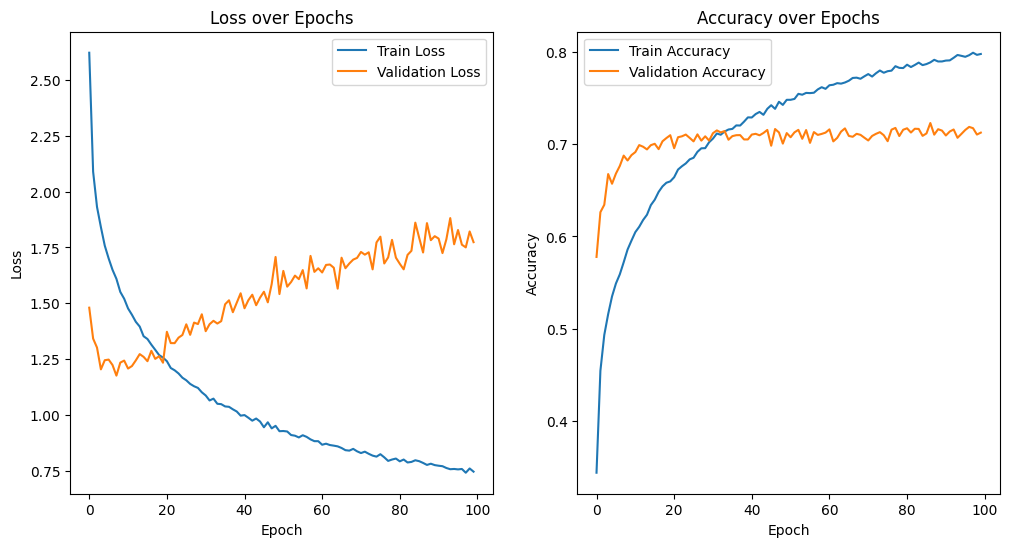

Training with batch_size=32, lr_layer4=0.0001,lr_fc=0.0005
Epoch [1/100], Train Loss: 2.6142, Train Acc: 0.3481, Val Loss: 1.4372, Val Acc: 0.5837
Epoch [2/100], Train Loss: 2.0400, Train Acc: 0.4642, Val Loss: 1.2751, Val Acc: 0.6275
Epoch [3/100], Train Loss: 1.8785, Train Acc: 0.5022, Val Loss: 1.2041, Val Acc: 0.6512
Epoch [4/100], Train Loss: 1.7734, Train Acc: 0.5280, Val Loss: 1.1693, Val Acc: 0.6704
Epoch [5/100], Train Loss: 1.6993, Train Acc: 0.5457, Val Loss: 1.1034, Val Acc: 0.6818
Epoch [6/100], Train Loss: 1.6321, Train Acc: 0.5645, Val Loss: 1.1281, Val Acc: 0.6792
Epoch [7/100], Train Loss: 1.5832, Train Acc: 0.5756, Val Loss: 1.1042, Val Acc: 0.6910
Epoch [8/100], Train Loss: 1.5282, Train Acc: 0.5886, Val Loss: 1.0921, Val Acc: 0.6933
Epoch [9/100], Train Loss: 1.4881, Train Acc: 0.5983, Val Loss: 1.1042, Val Acc: 0.6963
Epoch [10/100], Train Loss: 1.4615, Train Acc: 0.6066, Val Loss: 1.0691, Val Acc: 0.7025
Epoch [11/100], Train Loss: 1.4163, Train Acc: 0.6159, Val L

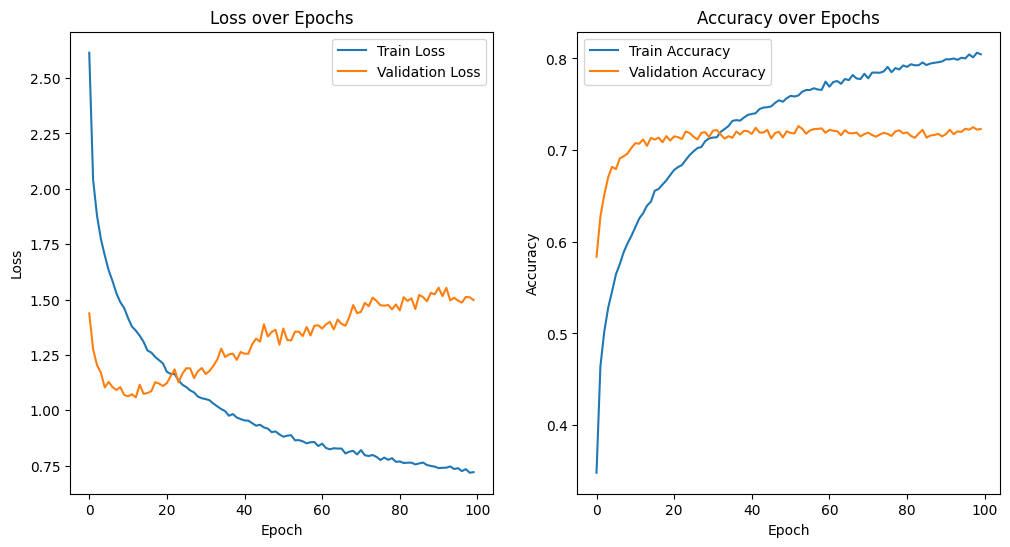

Training with batch_size=32, lr_layer4=0.0001,lr_fc=0.0001
Epoch [1/100], Train Loss: 2.7762, Train Acc: 0.3349, Val Loss: 1.5016, Val Acc: 0.5871
Epoch [2/100], Train Loss: 2.0667, Train Acc: 0.4662, Val Loss: 1.2696, Val Acc: 0.6429
Epoch [3/100], Train Loss: 1.8852, Train Acc: 0.5058, Val Loss: 1.1811, Val Acc: 0.6613
Epoch [4/100], Train Loss: 1.7610, Train Acc: 0.5359, Val Loss: 1.1185, Val Acc: 0.6831
Epoch [5/100], Train Loss: 1.6803, Train Acc: 0.5567, Val Loss: 1.0865, Val Acc: 0.6855
Epoch [6/100], Train Loss: 1.6109, Train Acc: 0.5735, Val Loss: 1.0513, Val Acc: 0.6927
Epoch [7/100], Train Loss: 1.5623, Train Acc: 0.5846, Val Loss: 1.0191, Val Acc: 0.7017
Epoch [8/100], Train Loss: 1.5018, Train Acc: 0.5998, Val Loss: 1.0052, Val Acc: 0.7075
Epoch [9/100], Train Loss: 1.4708, Train Acc: 0.6061, Val Loss: 0.9943, Val Acc: 0.7116
Epoch [10/100], Train Loss: 1.4236, Train Acc: 0.6175, Val Loss: 1.0049, Val Acc: 0.7110
Epoch [11/100], Train Loss: 1.4008, Train Acc: 0.6241, Val L

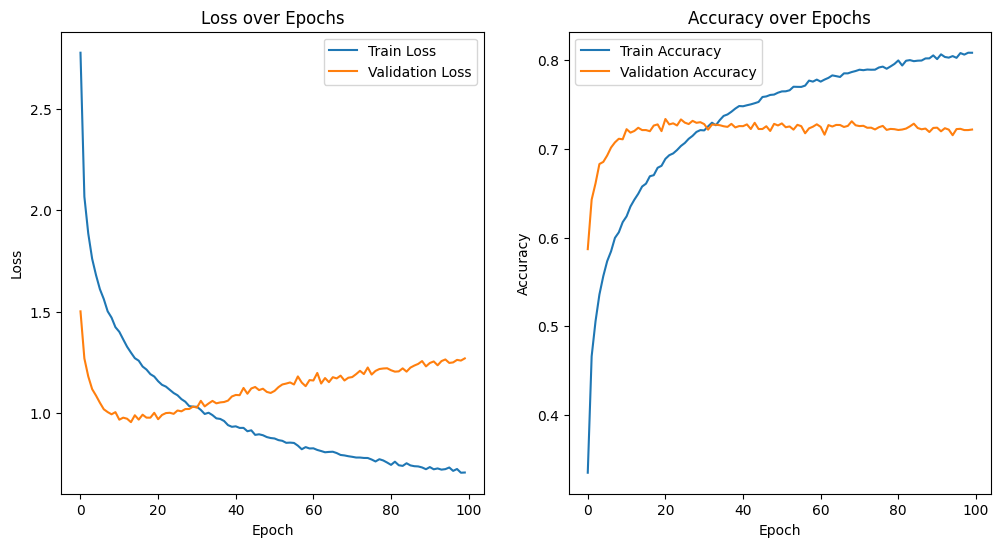

Training with batch_size=32, lr_layer4=5e-05,lr_fc=0.001
Epoch [1/100], Train Loss: 2.6734, Train Acc: 0.3327, Val Loss: 1.5130, Val Acc: 0.5720
Epoch [2/100], Train Loss: 2.1183, Train Acc: 0.4490, Val Loss: 1.3056, Val Acc: 0.6310
Epoch [3/100], Train Loss: 1.9814, Train Acc: 0.4818, Val Loss: 1.2598, Val Acc: 0.6415
Epoch [4/100], Train Loss: 1.8625, Train Acc: 0.5106, Val Loss: 1.2709, Val Acc: 0.6506
Epoch [5/100], Train Loss: 1.8025, Train Acc: 0.5212, Val Loss: 1.2735, Val Acc: 0.6535
Epoch [6/100], Train Loss: 1.7346, Train Acc: 0.5424, Val Loss: 1.1682, Val Acc: 0.6819
Epoch [7/100], Train Loss: 1.6883, Train Acc: 0.5522, Val Loss: 1.2117, Val Acc: 0.6713
Epoch [8/100], Train Loss: 1.6451, Train Acc: 0.5642, Val Loss: 1.1706, Val Acc: 0.6826
Epoch [9/100], Train Loss: 1.5793, Train Acc: 0.5782, Val Loss: 1.2078, Val Acc: 0.6836
Epoch [10/100], Train Loss: 1.5699, Train Acc: 0.5820, Val Loss: 1.1953, Val Acc: 0.6896
Epoch [11/100], Train Loss: 1.5273, Train Acc: 0.5901, Val Los

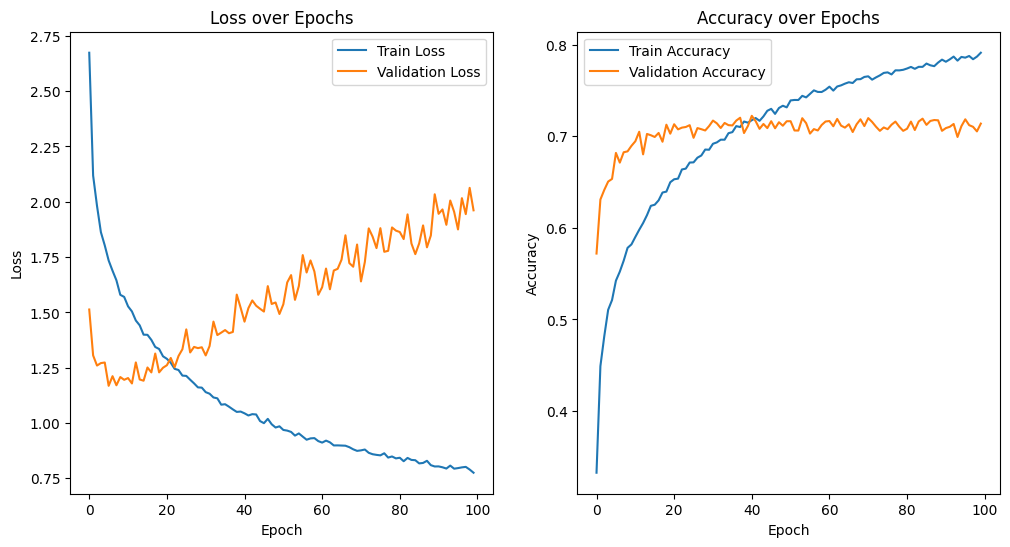

Training with batch_size=32, lr_layer4=5e-05,lr_fc=0.0005
Epoch [1/100], Train Loss: 2.7369, Train Acc: 0.3258, Val Loss: 1.4744, Val Acc: 0.5741
Epoch [2/100], Train Loss: 2.0976, Train Acc: 0.4493, Val Loss: 1.2998, Val Acc: 0.6199
Epoch [3/100], Train Loss: 1.9196, Train Acc: 0.4909, Val Loss: 1.2043, Val Acc: 0.6465
Epoch [4/100], Train Loss: 1.8059, Train Acc: 0.5214, Val Loss: 1.1324, Val Acc: 0.6723
Epoch [5/100], Train Loss: 1.7288, Train Acc: 0.5364, Val Loss: 1.1161, Val Acc: 0.6819
Epoch [6/100], Train Loss: 1.6731, Train Acc: 0.5548, Val Loss: 1.0908, Val Acc: 0.6858
Epoch [7/100], Train Loss: 1.6187, Train Acc: 0.5672, Val Loss: 1.0728, Val Acc: 0.6935
Epoch [8/100], Train Loss: 1.5638, Train Acc: 0.5805, Val Loss: 1.0487, Val Acc: 0.7015
Epoch [9/100], Train Loss: 1.5298, Train Acc: 0.5892, Val Loss: 1.0419, Val Acc: 0.7042
Epoch [10/100], Train Loss: 1.5107, Train Acc: 0.5949, Val Loss: 1.0685, Val Acc: 0.7018
Epoch [11/100], Train Loss: 1.4627, Train Acc: 0.6056, Val Lo

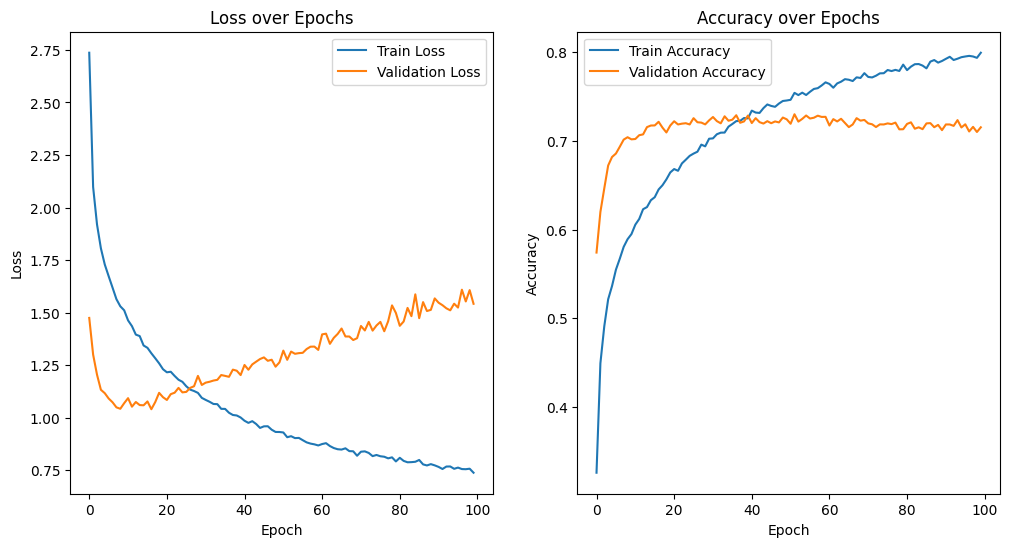

Training with batch_size=32, lr_layer4=5e-05,lr_fc=0.0001
Epoch [1/100], Train Loss: 2.9870, Train Acc: 0.2990, Val Loss: 1.6518, Val Acc: 0.5497
Epoch [2/100], Train Loss: 2.1903, Train Acc: 0.4426, Val Loss: 1.3553, Val Acc: 0.6176
Epoch [3/100], Train Loss: 1.9566, Train Acc: 0.4914, Val Loss: 1.2135, Val Acc: 0.6569
Epoch [4/100], Train Loss: 1.8322, Train Acc: 0.5219, Val Loss: 1.1541, Val Acc: 0.6672
Epoch [5/100], Train Loss: 1.7401, Train Acc: 0.5406, Val Loss: 1.0928, Val Acc: 0.6833
Epoch [6/100], Train Loss: 1.6722, Train Acc: 0.5568, Val Loss: 1.0502, Val Acc: 0.6939
Epoch [7/100], Train Loss: 1.6113, Train Acc: 0.5725, Val Loss: 1.0422, Val Acc: 0.6974
Epoch [8/100], Train Loss: 1.5585, Train Acc: 0.5867, Val Loss: 1.0369, Val Acc: 0.6973
Epoch [9/100], Train Loss: 1.5237, Train Acc: 0.5935, Val Loss: 1.0104, Val Acc: 0.7008
Epoch [10/100], Train Loss: 1.4730, Train Acc: 0.6080, Val Loss: 1.0061, Val Acc: 0.7110
Epoch [11/100], Train Loss: 1.4550, Train Acc: 0.6101, Val Lo

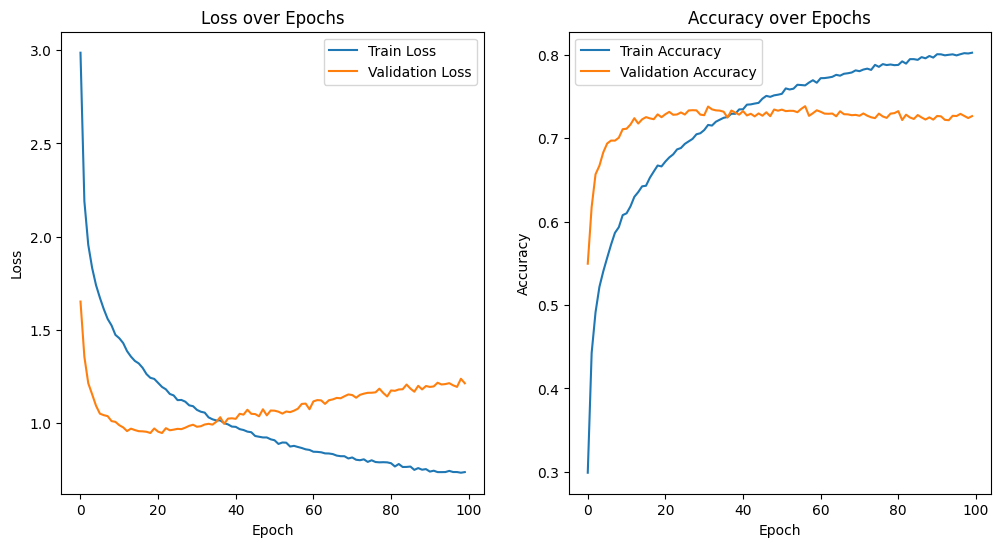

Training with batch_size=32, lr_layer4=1e-05,lr_fc=0.001
Epoch [1/100], Train Loss: 2.9341, Train Acc: 0.2842, Val Loss: 1.7057, Val Acc: 0.5239
Epoch [2/100], Train Loss: 2.3446, Train Acc: 0.3990, Val Loss: 1.5061, Val Acc: 0.5792
Epoch [3/100], Train Loss: 2.2020, Train Acc: 0.4322, Val Loss: 1.4249, Val Acc: 0.6021
Epoch [4/100], Train Loss: 2.1230, Train Acc: 0.4502, Val Loss: 1.3767, Val Acc: 0.6221
Epoch [5/100], Train Loss: 2.0574, Train Acc: 0.4668, Val Loss: 1.3566, Val Acc: 0.6253
Epoch [6/100], Train Loss: 1.9996, Train Acc: 0.4786, Val Loss: 1.3287, Val Acc: 0.6312
Epoch [7/100], Train Loss: 1.9664, Train Acc: 0.4873, Val Loss: 1.2885, Val Acc: 0.6435
Epoch [8/100], Train Loss: 1.9199, Train Acc: 0.4996, Val Loss: 1.2691, Val Acc: 0.6466
Epoch [9/100], Train Loss: 1.9020, Train Acc: 0.5020, Val Loss: 1.3161, Val Acc: 0.6411
Epoch [10/100], Train Loss: 1.8559, Train Acc: 0.5142, Val Loss: 1.2882, Val Acc: 0.6503
Epoch [11/100], Train Loss: 1.8424, Train Acc: 0.5166, Val Los

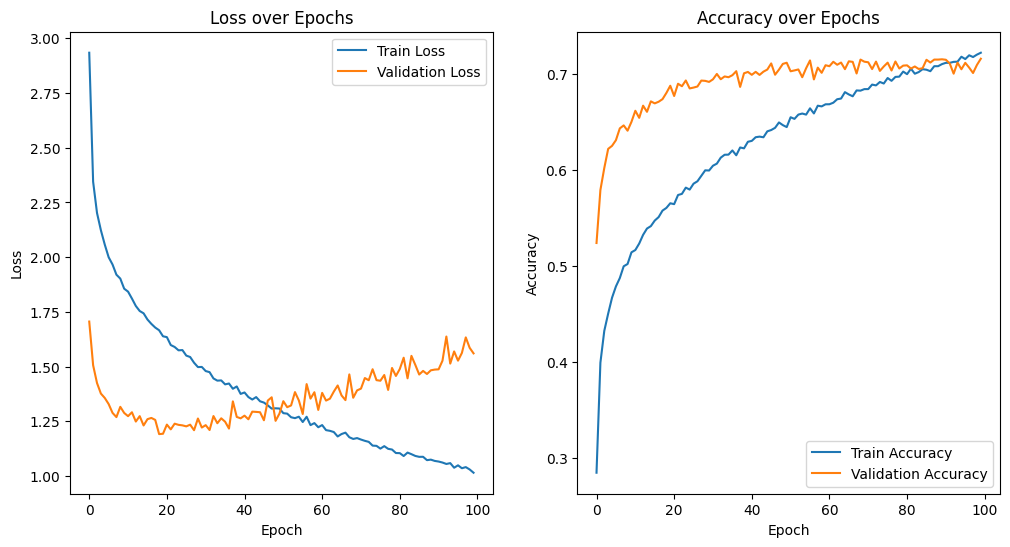

Training with batch_size=32, lr_layer4=1e-05,lr_fc=0.0005
Epoch [1/100], Train Loss: 3.0555, Train Acc: 0.2679, Val Loss: 1.7146, Val Acc: 0.5219
Epoch [2/100], Train Loss: 2.3143, Train Acc: 0.4027, Val Loss: 1.4700, Val Acc: 0.5843
Epoch [3/100], Train Loss: 2.1581, Train Acc: 0.4373, Val Loss: 1.3663, Val Acc: 0.6087
Epoch [4/100], Train Loss: 2.0568, Train Acc: 0.4612, Val Loss: 1.3151, Val Acc: 0.6228
Epoch [5/100], Train Loss: 1.9940, Train Acc: 0.4789, Val Loss: 1.2534, Val Acc: 0.6406
Epoch [6/100], Train Loss: 1.9395, Train Acc: 0.4887, Val Loss: 1.2176, Val Acc: 0.6507
Epoch [7/100], Train Loss: 1.8866, Train Acc: 0.5021, Val Loss: 1.1716, Val Acc: 0.6650
Epoch [8/100], Train Loss: 1.8477, Train Acc: 0.5091, Val Loss: 1.1889, Val Acc: 0.6640
Epoch [9/100], Train Loss: 1.8154, Train Acc: 0.5183, Val Loss: 1.1552, Val Acc: 0.6728
Epoch [10/100], Train Loss: 1.7804, Train Acc: 0.5264, Val Loss: 1.1745, Val Acc: 0.6640
Epoch [11/100], Train Loss: 1.7472, Train Acc: 0.5341, Val Lo

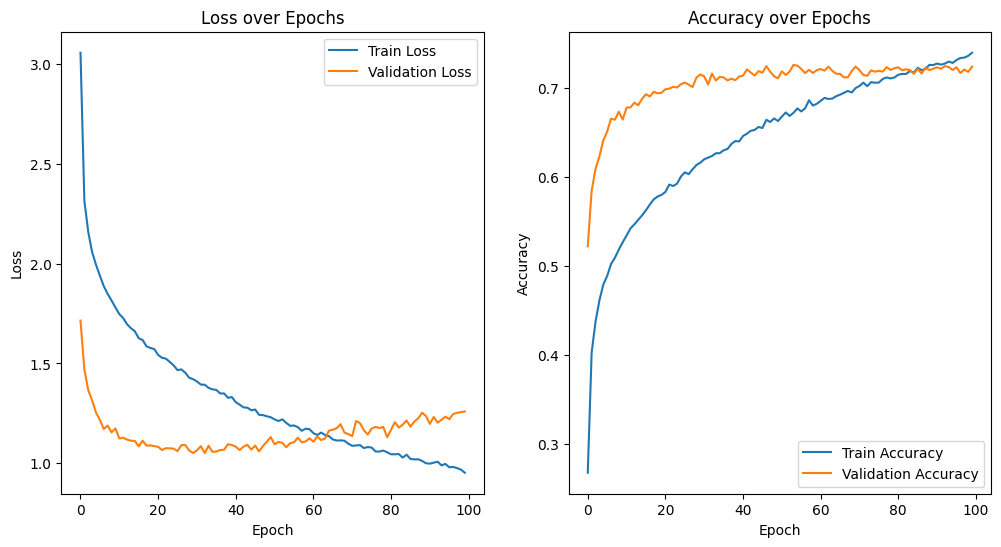

Training with batch_size=32, lr_layer4=1e-05,lr_fc=0.0001
Epoch [1/100], Train Loss: 3.6107, Train Acc: 0.1900, Val Loss: 2.3154, Val Acc: 0.4204
Epoch [2/100], Train Loss: 2.6446, Train Acc: 0.3551, Val Loss: 1.7672, Val Acc: 0.5181
Epoch [3/100], Train Loss: 2.3376, Train Acc: 0.4089, Val Loss: 1.5356, Val Acc: 0.5681
Epoch [4/100], Train Loss: 2.1869, Train Acc: 0.4406, Val Loss: 1.3937, Val Acc: 0.6044
Epoch [5/100], Train Loss: 2.0708, Train Acc: 0.4642, Val Loss: 1.3207, Val Acc: 0.6206
Epoch [6/100], Train Loss: 2.0032, Train Acc: 0.4780, Val Loss: 1.2665, Val Acc: 0.6358
Epoch [7/100], Train Loss: 1.9358, Train Acc: 0.4899, Val Loss: 1.2242, Val Acc: 0.6461
Epoch [8/100], Train Loss: 1.8913, Train Acc: 0.5041, Val Loss: 1.1831, Val Acc: 0.6583
Epoch [9/100], Train Loss: 1.8533, Train Acc: 0.5117, Val Loss: 1.1543, Val Acc: 0.6642
Epoch [10/100], Train Loss: 1.8005, Train Acc: 0.5241, Val Loss: 1.1280, Val Acc: 0.6732
Epoch [11/100], Train Loss: 1.7830, Train Acc: 0.5299, Val Lo

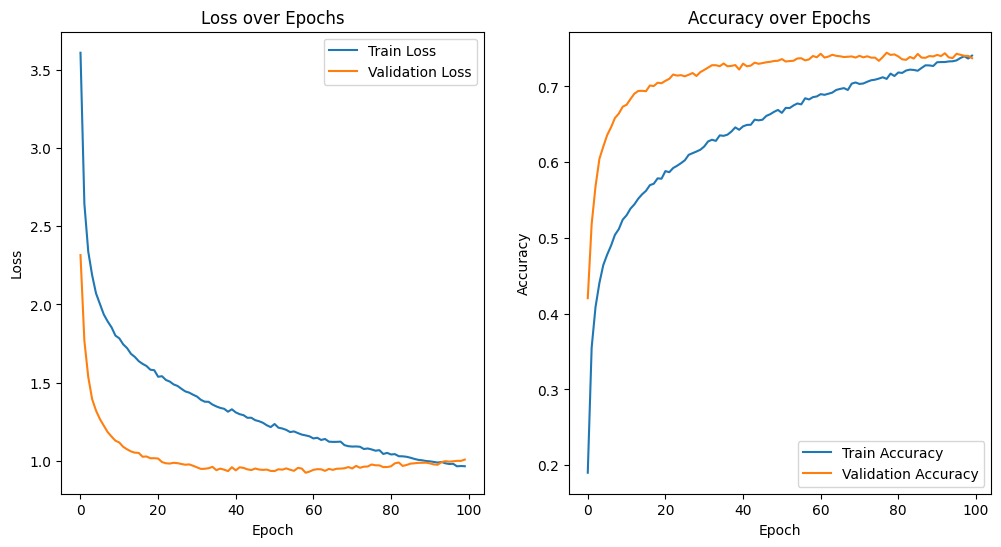

Training with batch_size=64, lr_layer4=0.0001,lr_fc=0.001
Epoch [1/100], Train Loss: 2.6081, Train Acc: 0.3473, Val Loss: 1.4141, Val Acc: 0.5902
Epoch [2/100], Train Loss: 2.0121, Train Acc: 0.4699, Val Loss: 1.2863, Val Acc: 0.6309
Epoch [3/100], Train Loss: 1.8404, Train Acc: 0.5110, Val Loss: 1.1836, Val Acc: 0.6600
Epoch [4/100], Train Loss: 1.7452, Train Acc: 0.5334, Val Loss: 1.1769, Val Acc: 0.6719
Epoch [5/100], Train Loss: 1.6588, Train Acc: 0.5560, Val Loss: 1.1566, Val Acc: 0.6744
Epoch [6/100], Train Loss: 1.5946, Train Acc: 0.5711, Val Loss: 1.1291, Val Acc: 0.6860
Epoch [7/100], Train Loss: 1.5420, Train Acc: 0.5848, Val Loss: 1.1031, Val Acc: 0.6934
Epoch [8/100], Train Loss: 1.4962, Train Acc: 0.5980, Val Loss: 1.1492, Val Acc: 0.6852
Epoch [9/100], Train Loss: 1.4599, Train Acc: 0.6067, Val Loss: 1.1159, Val Acc: 0.6940
Epoch [10/100], Train Loss: 1.4196, Train Acc: 0.6154, Val Loss: 1.1178, Val Acc: 0.6952
Epoch [11/100], Train Loss: 1.3731, Train Acc: 0.6264, Val Lo

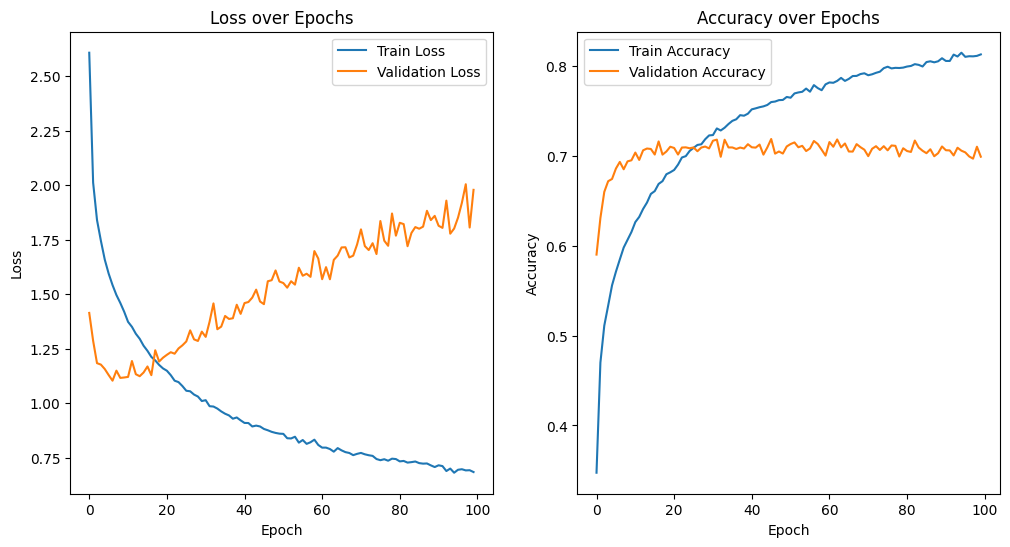

Training with batch_size=64, lr_layer4=0.0001,lr_fc=0.0005
Epoch [1/100], Train Loss: 2.6582, Train Acc: 0.3433, Val Loss: 1.4630, Val Acc: 0.5879
Epoch [2/100], Train Loss: 1.9991, Train Acc: 0.4739, Val Loss: 1.2484, Val Acc: 0.6396
Epoch [3/100], Train Loss: 1.8180, Train Acc: 0.5153, Val Loss: 1.1737, Val Acc: 0.6604
Epoch [4/100], Train Loss: 1.7092, Train Acc: 0.5427, Val Loss: 1.1091, Val Acc: 0.6827
Epoch [5/100], Train Loss: 1.6436, Train Acc: 0.5597, Val Loss: 1.0804, Val Acc: 0.6874
Epoch [6/100], Train Loss: 1.5684, Train Acc: 0.5760, Val Loss: 1.0858, Val Acc: 0.6879
Epoch [7/100], Train Loss: 1.5005, Train Acc: 0.5950, Val Loss: 1.0357, Val Acc: 0.7034
Epoch [8/100], Train Loss: 1.4704, Train Acc: 0.6014, Val Loss: 1.0320, Val Acc: 0.7003
Epoch [9/100], Train Loss: 1.4254, Train Acc: 0.6135, Val Loss: 1.0599, Val Acc: 0.6971
Epoch [10/100], Train Loss: 1.3839, Train Acc: 0.6257, Val Loss: 1.0496, Val Acc: 0.6965
Epoch [11/100], Train Loss: 1.3516, Train Acc: 0.6312, Val L

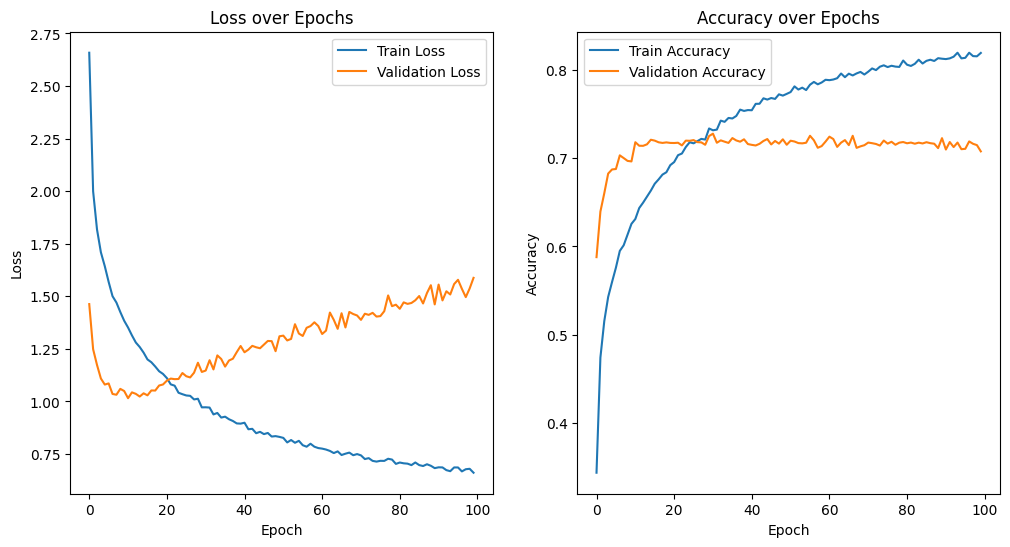

Training with batch_size=64, lr_layer4=0.0001,lr_fc=0.0001
Epoch [1/100], Train Loss: 2.8742, Train Acc: 0.3236, Val Loss: 1.6183, Val Acc: 0.5698
Epoch [2/100], Train Loss: 2.0816, Train Acc: 0.4674, Val Loss: 1.2998, Val Acc: 0.6398
Epoch [3/100], Train Loss: 1.8739, Train Acc: 0.5103, Val Loss: 1.2002, Val Acc: 0.6596
Epoch [4/100], Train Loss: 1.7466, Train Acc: 0.5399, Val Loss: 1.1203, Val Acc: 0.6807
Epoch [5/100], Train Loss: 1.6516, Train Acc: 0.5650, Val Loss: 1.0734, Val Acc: 0.6928
Epoch [6/100], Train Loss: 1.5788, Train Acc: 0.5821, Val Loss: 1.0660, Val Acc: 0.6917
Epoch [7/100], Train Loss: 1.5189, Train Acc: 0.5947, Val Loss: 1.0312, Val Acc: 0.6971
Epoch [8/100], Train Loss: 1.4537, Train Acc: 0.6102, Val Loss: 1.0112, Val Acc: 0.7065
Epoch [9/100], Train Loss: 1.4202, Train Acc: 0.6186, Val Loss: 0.9941, Val Acc: 0.7098
Epoch [10/100], Train Loss: 1.3826, Train Acc: 0.6284, Val Loss: 0.9721, Val Acc: 0.7168
Epoch [11/100], Train Loss: 1.3396, Train Acc: 0.6389, Val L

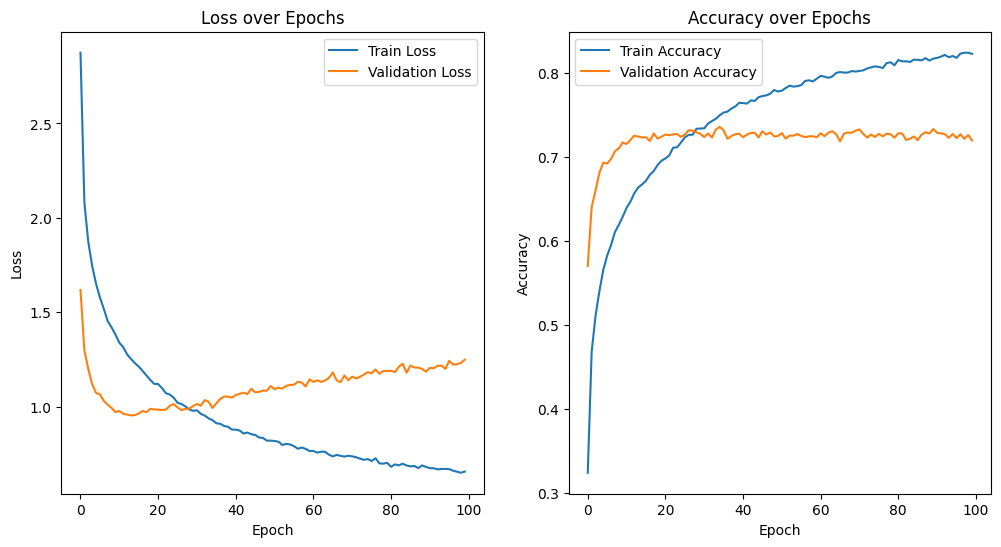

Training with batch_size=64, lr_layer4=5e-05,lr_fc=0.001
Epoch [1/100], Train Loss: 2.7241, Train Acc: 0.3247, Val Loss: 1.4898, Val Acc: 0.5715
Epoch [2/100], Train Loss: 2.0623, Train Acc: 0.4573, Val Loss: 1.2884, Val Acc: 0.6242
Epoch [3/100], Train Loss: 1.9045, Train Acc: 0.4932, Val Loss: 1.2295, Val Acc: 0.6454
Epoch [4/100], Train Loss: 1.8057, Train Acc: 0.5190, Val Loss: 1.2166, Val Acc: 0.6521
Epoch [5/100], Train Loss: 1.7258, Train Acc: 0.5395, Val Loss: 1.1721, Val Acc: 0.6693
Epoch [6/100], Train Loss: 1.6614, Train Acc: 0.5529, Val Loss: 1.1396, Val Acc: 0.6780
Epoch [7/100], Train Loss: 1.6081, Train Acc: 0.5676, Val Loss: 1.1602, Val Acc: 0.6783
Epoch [8/100], Train Loss: 1.5648, Train Acc: 0.5776, Val Loss: 1.1306, Val Acc: 0.6862
Epoch [9/100], Train Loss: 1.5151, Train Acc: 0.5905, Val Loss: 1.1180, Val Acc: 0.6923
Epoch [10/100], Train Loss: 1.4898, Train Acc: 0.5984, Val Loss: 1.1059, Val Acc: 0.6976
Epoch [11/100], Train Loss: 1.4482, Train Acc: 0.6084, Val Los

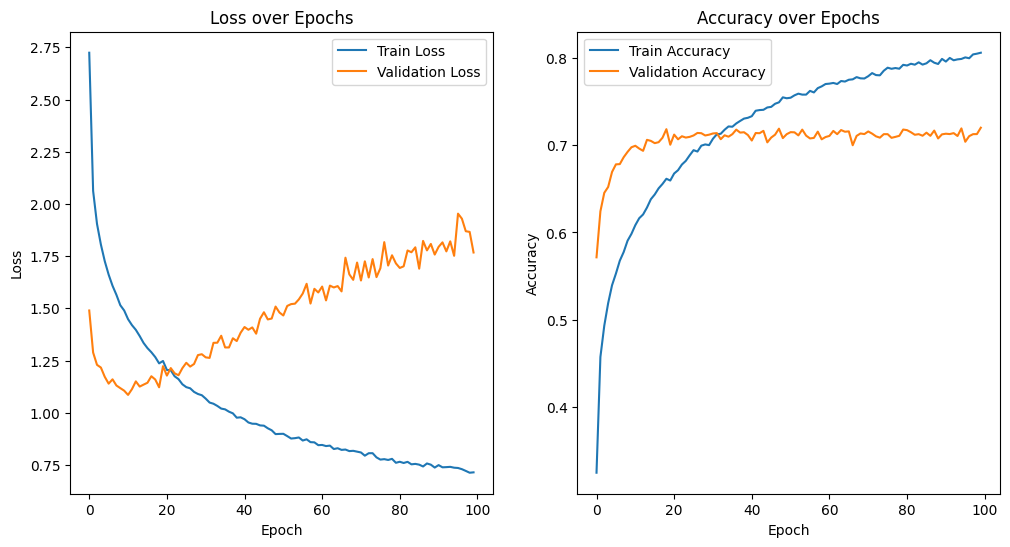

Training with batch_size=64, lr_layer4=5e-05,lr_fc=0.0005
Epoch [1/100], Train Loss: 2.8313, Train Acc: 0.3106, Val Loss: 1.5437, Val Acc: 0.5624
Epoch [2/100], Train Loss: 2.0846, Train Acc: 0.4527, Val Loss: 1.2988, Val Acc: 0.6227
Epoch [3/100], Train Loss: 1.8983, Train Acc: 0.4980, Val Loss: 1.1802, Val Acc: 0.6582
Epoch [4/100], Train Loss: 1.7824, Train Acc: 0.5278, Val Loss: 1.1437, Val Acc: 0.6680
Epoch [5/100], Train Loss: 1.6965, Train Acc: 0.5462, Val Loss: 1.1069, Val Acc: 0.6786
Epoch [6/100], Train Loss: 1.6363, Train Acc: 0.5595, Val Loss: 1.0771, Val Acc: 0.6841
Epoch [7/100], Train Loss: 1.5810, Train Acc: 0.5763, Val Loss: 1.0700, Val Acc: 0.6924
Epoch [8/100], Train Loss: 1.5347, Train Acc: 0.5850, Val Loss: 1.0402, Val Acc: 0.7026
Epoch [9/100], Train Loss: 1.4836, Train Acc: 0.5961, Val Loss: 1.0422, Val Acc: 0.7017
Epoch [10/100], Train Loss: 1.4628, Train Acc: 0.6049, Val Loss: 1.0169, Val Acc: 0.7028
Epoch [11/100], Train Loss: 1.4206, Train Acc: 0.6144, Val Lo

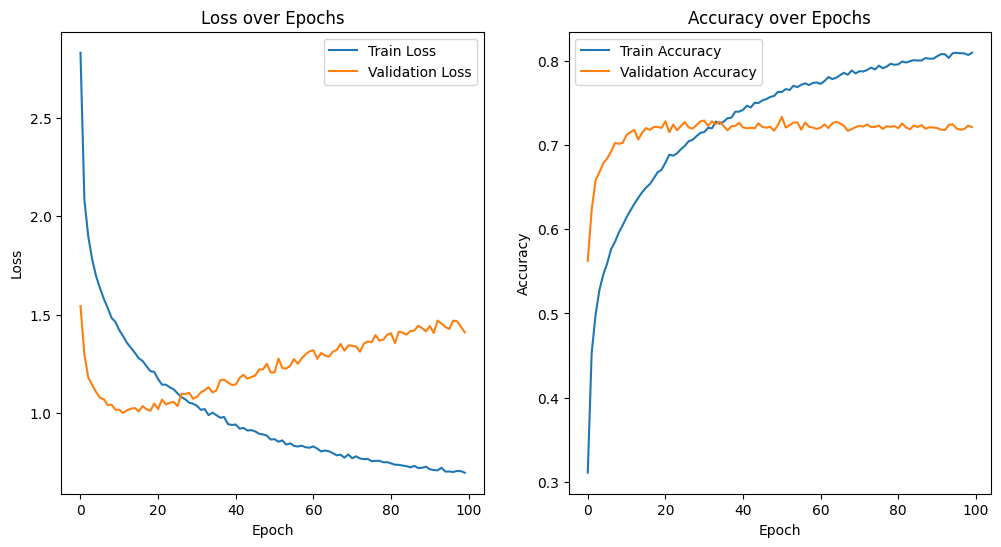

Training with batch_size=64, lr_layer4=5e-05,lr_fc=0.0001
Epoch [1/100], Train Loss: 3.1497, Train Acc: 0.2753, Val Loss: 1.8270, Val Acc: 0.5231
Epoch [2/100], Train Loss: 2.2588, Train Acc: 0.4321, Val Loss: 1.4521, Val Acc: 0.6007
Epoch [3/100], Train Loss: 1.9992, Train Acc: 0.4835, Val Loss: 1.2882, Val Acc: 0.6366
Epoch [4/100], Train Loss: 1.8583, Train Acc: 0.5151, Val Loss: 1.2072, Val Acc: 0.6557
Epoch [5/100], Train Loss: 1.7598, Train Acc: 0.5376, Val Loss: 1.1463, Val Acc: 0.6710
Epoch [6/100], Train Loss: 1.6843, Train Acc: 0.5550, Val Loss: 1.0950, Val Acc: 0.6854
Epoch [7/100], Train Loss: 1.6230, Train Acc: 0.5714, Val Loss: 1.0461, Val Acc: 0.6972
Epoch [8/100], Train Loss: 1.5644, Train Acc: 0.5833, Val Loss: 1.0336, Val Acc: 0.7000
Epoch [9/100], Train Loss: 1.5253, Train Acc: 0.5910, Val Loss: 1.0239, Val Acc: 0.7041
Epoch [10/100], Train Loss: 1.4722, Train Acc: 0.6059, Val Loss: 1.0066, Val Acc: 0.7070
Epoch [11/100], Train Loss: 1.4429, Train Acc: 0.6144, Val Lo

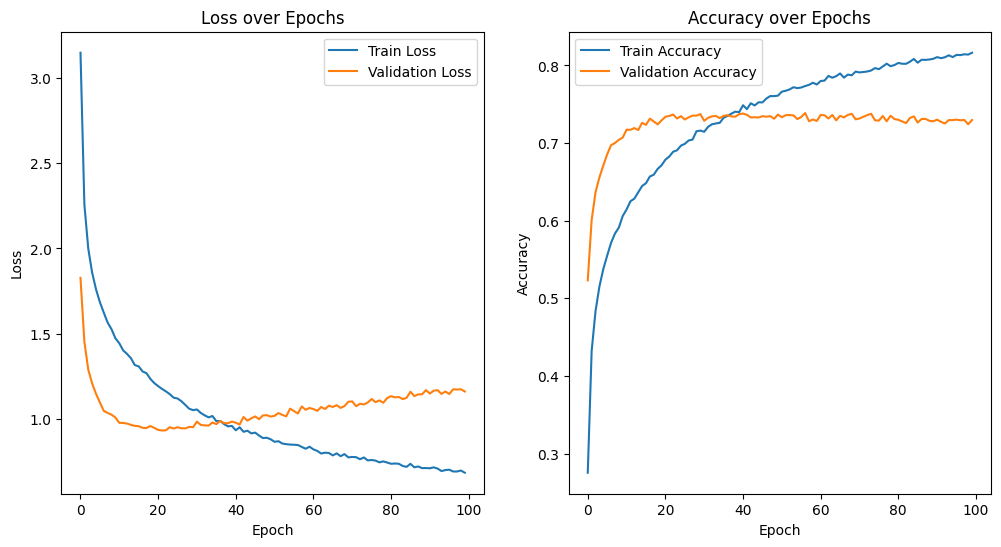

Training with batch_size=64, lr_layer4=1e-05,lr_fc=0.001
Epoch [1/100], Train Loss: 3.0024, Train Acc: 0.2797, Val Loss: 1.7559, Val Acc: 0.5122
Epoch [2/100], Train Loss: 2.3113, Train Acc: 0.4052, Val Loss: 1.4797, Val Acc: 0.5777
Epoch [3/100], Train Loss: 2.1635, Train Acc: 0.4390, Val Loss: 1.3813, Val Acc: 0.6055
Epoch [4/100], Train Loss: 2.0537, Train Acc: 0.4636, Val Loss: 1.3401, Val Acc: 0.6157
Epoch [5/100], Train Loss: 2.0045, Train Acc: 0.4746, Val Loss: 1.3318, Val Acc: 0.6250
Epoch [6/100], Train Loss: 1.9553, Train Acc: 0.4872, Val Loss: 1.2758, Val Acc: 0.6380
Epoch [7/100], Train Loss: 1.9109, Train Acc: 0.4978, Val Loss: 1.2552, Val Acc: 0.6452
Epoch [8/100], Train Loss: 1.8774, Train Acc: 0.5064, Val Loss: 1.2396, Val Acc: 0.6512
Epoch [9/100], Train Loss: 1.8369, Train Acc: 0.5139, Val Loss: 1.2620, Val Acc: 0.6500
Epoch [10/100], Train Loss: 1.8145, Train Acc: 0.5188, Val Loss: 1.2245, Val Acc: 0.6535
Epoch [11/100], Train Loss: 1.7835, Train Acc: 0.5260, Val Los

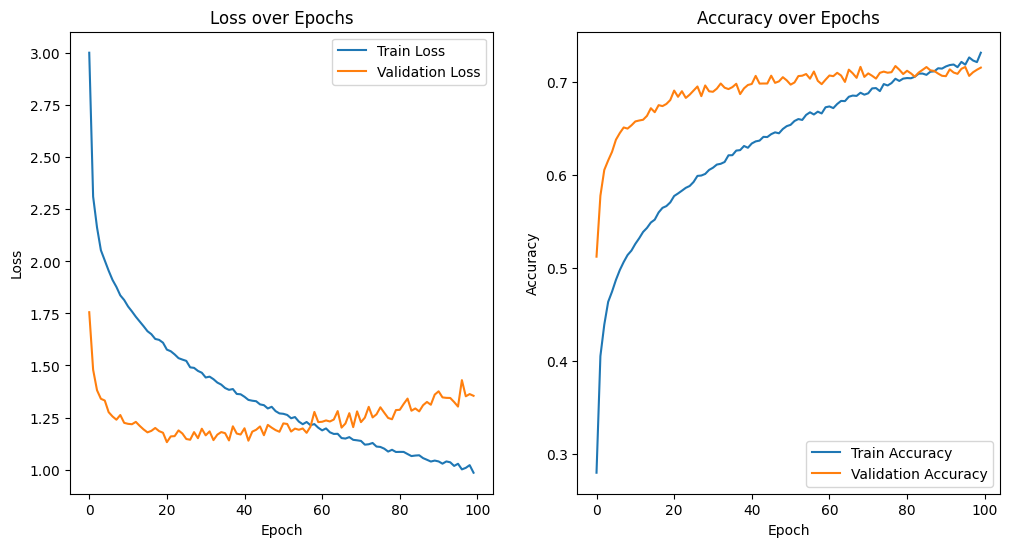

Training with batch_size=64, lr_layer4=1e-05,lr_fc=0.0005
Epoch [1/100], Train Loss: 3.2118, Train Acc: 0.2473, Val Loss: 1.8631, Val Acc: 0.4995
Epoch [2/100], Train Loss: 2.3696, Train Acc: 0.3951, Val Loss: 1.5252, Val Acc: 0.5706
Epoch [3/100], Train Loss: 2.1685, Train Acc: 0.4359, Val Loss: 1.3982, Val Acc: 0.5958
Epoch [4/100], Train Loss: 2.0553, Train Acc: 0.4621, Val Loss: 1.3124, Val Acc: 0.6218
Epoch [5/100], Train Loss: 1.9865, Train Acc: 0.4764, Val Loss: 1.2738, Val Acc: 0.6333
Epoch [6/100], Train Loss: 1.9327, Train Acc: 0.4891, Val Loss: 1.2321, Val Acc: 0.6441
Epoch [7/100], Train Loss: 1.8859, Train Acc: 0.5021, Val Loss: 1.1949, Val Acc: 0.6555
Epoch [8/100], Train Loss: 1.8400, Train Acc: 0.5141, Val Loss: 1.2106, Val Acc: 0.6486
Epoch [9/100], Train Loss: 1.8133, Train Acc: 0.5180, Val Loss: 1.1628, Val Acc: 0.6636
Epoch [10/100], Train Loss: 1.7654, Train Acc: 0.5299, Val Loss: 1.1371, Val Acc: 0.6668
Epoch [11/100], Train Loss: 1.7438, Train Acc: 0.5330, Val Lo

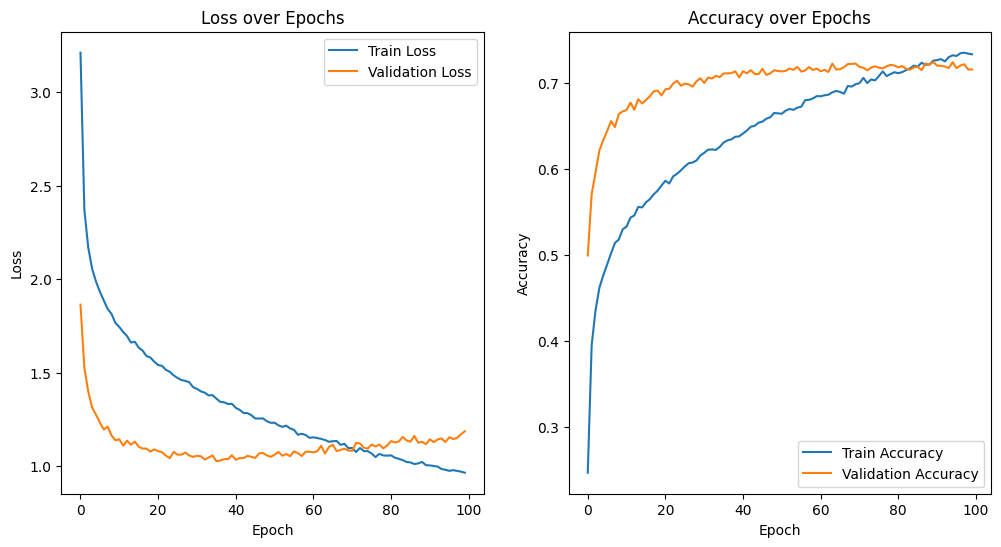

Training with batch_size=64, lr_layer4=1e-05,lr_fc=0.0001
Epoch [1/100], Train Loss: 3.8201, Train Acc: 0.1590, Val Loss: 2.6801, Val Acc: 0.3620
Epoch [2/100], Train Loss: 2.8185, Train Acc: 0.3299, Val Loss: 1.9723, Val Acc: 0.4876
Epoch [3/100], Train Loss: 2.4614, Train Acc: 0.3883, Val Loss: 1.6903, Val Acc: 0.5436
Epoch [4/100], Train Loss: 2.2744, Train Acc: 0.4249, Val Loss: 1.5349, Val Acc: 0.5689
Epoch [5/100], Train Loss: 2.1520, Train Acc: 0.4467, Val Loss: 1.4419, Val Acc: 0.5964
Epoch [6/100], Train Loss: 2.0692, Train Acc: 0.4637, Val Loss: 1.3609, Val Acc: 0.6171
Epoch [7/100], Train Loss: 1.9988, Train Acc: 0.4785, Val Loss: 1.2944, Val Acc: 0.6315
Epoch [8/100], Train Loss: 1.9272, Train Acc: 0.4957, Val Loss: 1.2543, Val Acc: 0.6435
Epoch [9/100], Train Loss: 1.8865, Train Acc: 0.5054, Val Loss: 1.2185, Val Acc: 0.6517
Epoch [10/100], Train Loss: 1.8498, Train Acc: 0.5130, Val Loss: 1.1900, Val Acc: 0.6581
Epoch [11/100], Train Loss: 1.8150, Train Acc: 0.5225, Val Lo

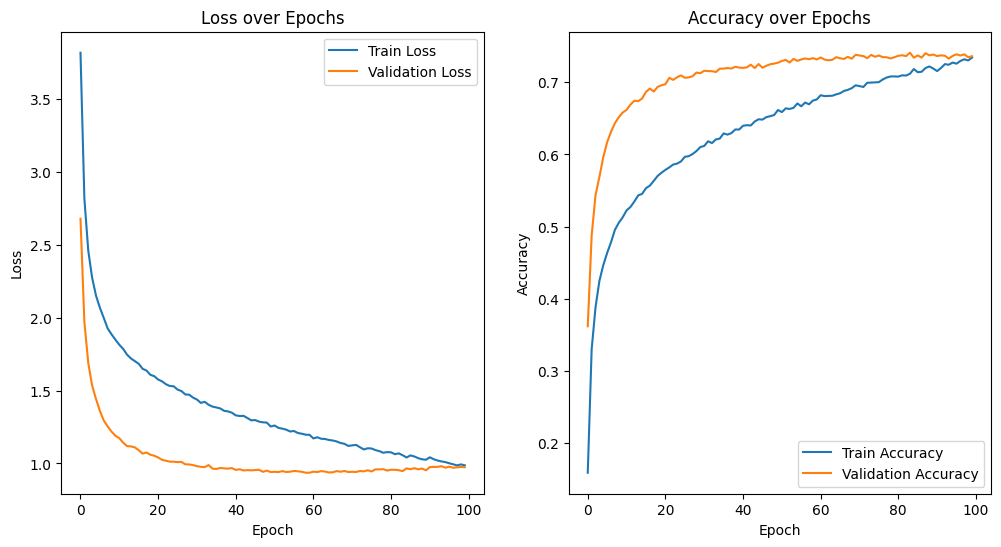

Training with batch_size=128, lr_layer4=0.0001,lr_fc=0.001
Epoch [1/100], Train Loss: 2.6898, Train Acc: 0.3342, Val Loss: 1.4878, Val Acc: 0.5767
Epoch [2/100], Train Loss: 1.9944, Train Acc: 0.4736, Val Loss: 1.3010, Val Acc: 0.6234
Epoch [3/100], Train Loss: 1.8201, Train Acc: 0.5146, Val Loss: 1.2069, Val Acc: 0.6521
Epoch [4/100], Train Loss: 1.7113, Train Acc: 0.5426, Val Loss: 1.1478, Val Acc: 0.6688
Epoch [5/100], Train Loss: 1.6304, Train Acc: 0.5622, Val Loss: 1.1049, Val Acc: 0.6866
Epoch [6/100], Train Loss: 1.5645, Train Acc: 0.5760, Val Loss: 1.1100, Val Acc: 0.6871
Epoch [7/100], Train Loss: 1.5085, Train Acc: 0.5910, Val Loss: 1.0823, Val Acc: 0.6883
Epoch [8/100], Train Loss: 1.4456, Train Acc: 0.6060, Val Loss: 1.0892, Val Acc: 0.6976
Epoch [9/100], Train Loss: 1.4062, Train Acc: 0.6176, Val Loss: 1.0749, Val Acc: 0.6985
Epoch [10/100], Train Loss: 1.3735, Train Acc: 0.6270, Val Loss: 1.0767, Val Acc: 0.7025
Epoch [11/100], Train Loss: 1.3475, Train Acc: 0.6330, Val L

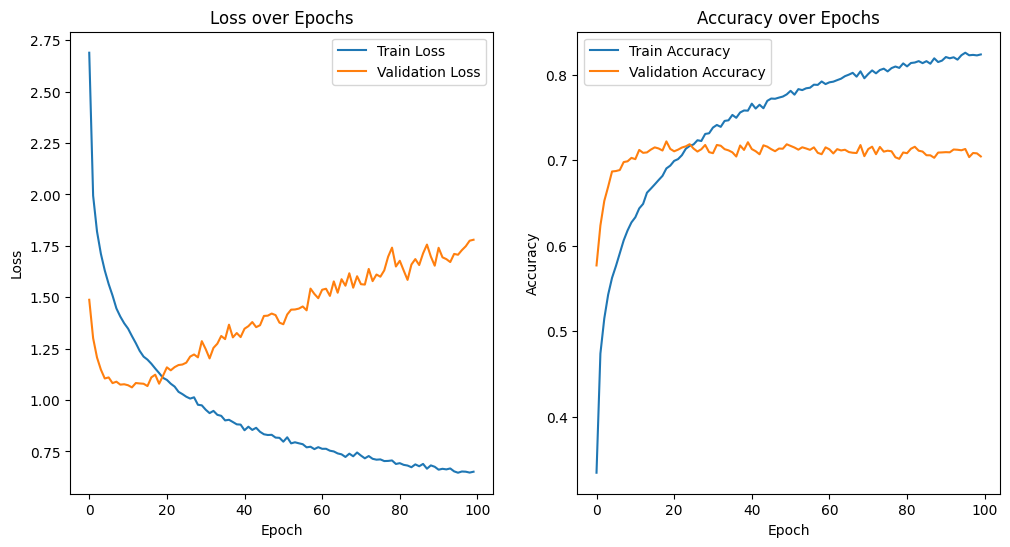

Training with batch_size=128, lr_layer4=0.0001,lr_fc=0.0005
Epoch [1/100], Train Loss: 2.7992, Train Acc: 0.3210, Val Loss: 1.5121, Val Acc: 0.5772
Epoch [2/100], Train Loss: 2.0115, Train Acc: 0.4740, Val Loss: 1.3021, Val Acc: 0.6265
Epoch [3/100], Train Loss: 1.8282, Train Acc: 0.5145, Val Loss: 1.1806, Val Acc: 0.6574
Epoch [4/100], Train Loss: 1.7090, Train Acc: 0.5440, Val Loss: 1.1050, Val Acc: 0.6764
Epoch [5/100], Train Loss: 1.6198, Train Acc: 0.5644, Val Loss: 1.0770, Val Acc: 0.6836
Epoch [6/100], Train Loss: 1.5462, Train Acc: 0.5830, Val Loss: 1.0536, Val Acc: 0.6907
Epoch [7/100], Train Loss: 1.4936, Train Acc: 0.5967, Val Loss: 1.0381, Val Acc: 0.6989
Epoch [8/100], Train Loss: 1.4538, Train Acc: 0.6076, Val Loss: 1.0154, Val Acc: 0.7037
Epoch [9/100], Train Loss: 1.4082, Train Acc: 0.6174, Val Loss: 1.0182, Val Acc: 0.7037
Epoch [10/100], Train Loss: 1.3596, Train Acc: 0.6312, Val Loss: 1.0310, Val Acc: 0.7060
Epoch [11/100], Train Loss: 1.3191, Train Acc: 0.6393, Val 

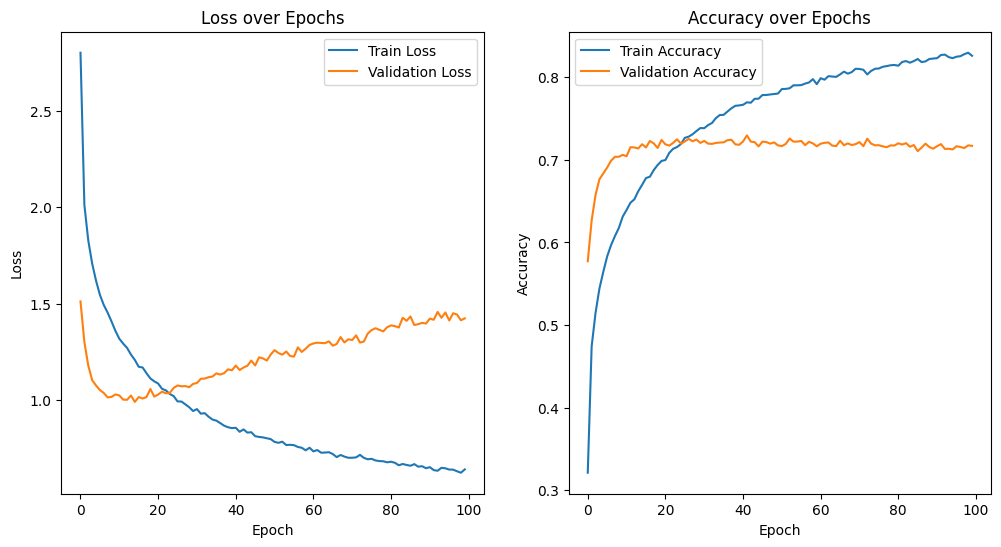

Training with batch_size=128, lr_layer4=0.0001,lr_fc=0.0001
Epoch [1/100], Train Loss: 3.0466, Train Acc: 0.3009, Val Loss: 1.7848, Val Acc: 0.5429
Epoch [2/100], Train Loss: 2.1683, Train Acc: 0.4591, Val Loss: 1.3957, Val Acc: 0.6153
Epoch [3/100], Train Loss: 1.9252, Train Acc: 0.5022, Val Loss: 1.2776, Val Acc: 0.6440
Epoch [4/100], Train Loss: 1.7803, Train Acc: 0.5355, Val Loss: 1.1752, Val Acc: 0.6607
Epoch [5/100], Train Loss: 1.6848, Train Acc: 0.5583, Val Loss: 1.0986, Val Acc: 0.6916
Epoch [6/100], Train Loss: 1.5973, Train Acc: 0.5790, Val Loss: 1.0731, Val Acc: 0.6904
Epoch [7/100], Train Loss: 1.5383, Train Acc: 0.5898, Val Loss: 1.0322, Val Acc: 0.7021
Epoch [8/100], Train Loss: 1.4886, Train Acc: 0.6034, Val Loss: 1.0183, Val Acc: 0.7062
Epoch [9/100], Train Loss: 1.4336, Train Acc: 0.6191, Val Loss: 1.0120, Val Acc: 0.7061
Epoch [10/100], Train Loss: 1.3968, Train Acc: 0.6258, Val Loss: 0.9708, Val Acc: 0.7191
Epoch [11/100], Train Loss: 1.3689, Train Acc: 0.6334, Val 

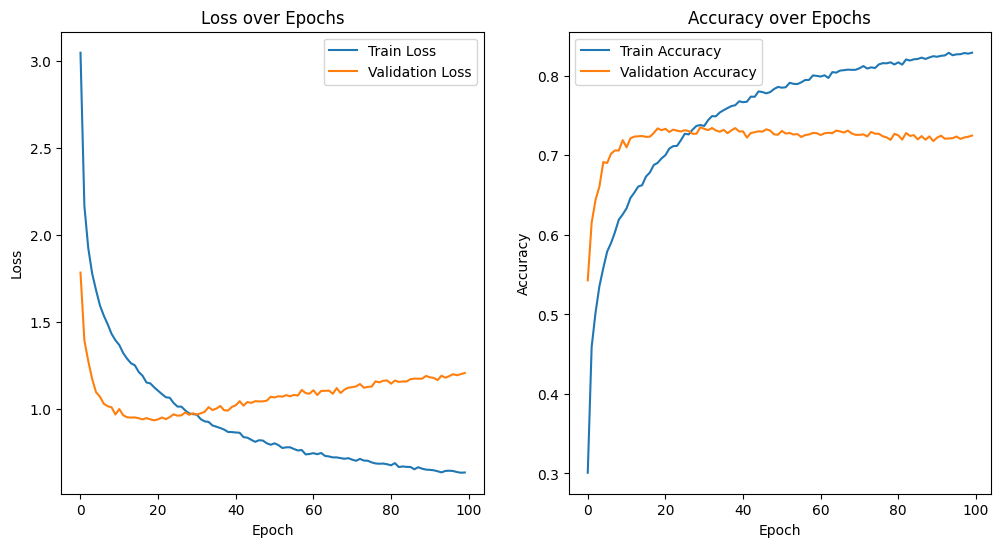

Training with batch_size=128, lr_layer4=5e-05,lr_fc=0.001
Epoch [1/100], Train Loss: 2.8368, Train Acc: 0.3074, Val Loss: 1.5201, Val Acc: 0.5706
Epoch [2/100], Train Loss: 2.0843, Train Acc: 0.4534, Val Loss: 1.3153, Val Acc: 0.6171
Epoch [3/100], Train Loss: 1.9001, Train Acc: 0.4968, Val Loss: 1.2450, Val Acc: 0.6463
Epoch [4/100], Train Loss: 1.7998, Train Acc: 0.5192, Val Loss: 1.1737, Val Acc: 0.6558
Epoch [5/100], Train Loss: 1.7077, Train Acc: 0.5425, Val Loss: 1.1400, Val Acc: 0.6723
Epoch [6/100], Train Loss: 1.6580, Train Acc: 0.5559, Val Loss: 1.1331, Val Acc: 0.6648
Epoch [7/100], Train Loss: 1.6002, Train Acc: 0.5692, Val Loss: 1.1102, Val Acc: 0.6793
Epoch [8/100], Train Loss: 1.5527, Train Acc: 0.5799, Val Loss: 1.0896, Val Acc: 0.6865
Epoch [9/100], Train Loss: 1.5094, Train Acc: 0.5907, Val Loss: 1.0722, Val Acc: 0.6951
Epoch [10/100], Train Loss: 1.4704, Train Acc: 0.6012, Val Loss: 1.0853, Val Acc: 0.6915
Epoch [11/100], Train Loss: 1.4400, Train Acc: 0.6098, Val Lo

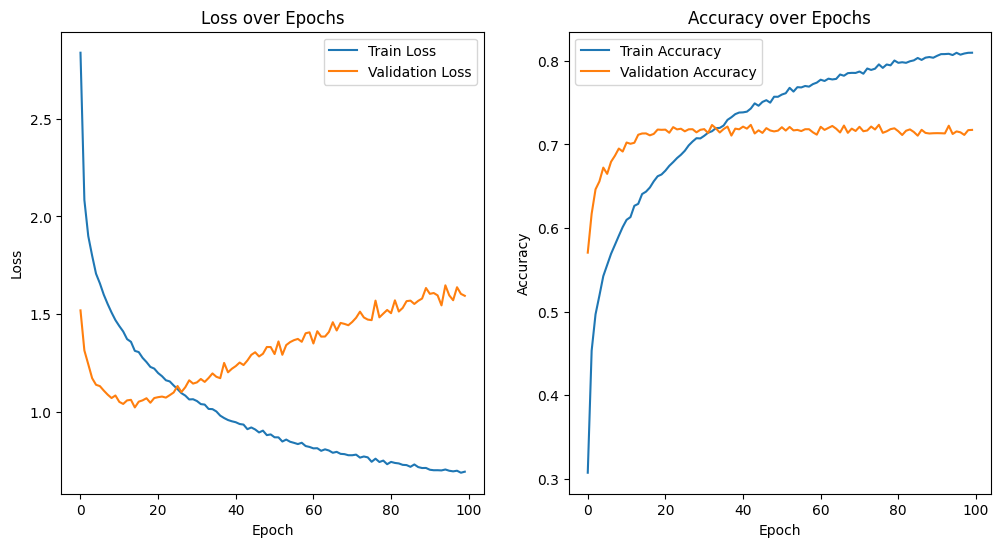

Training with batch_size=128, lr_layer4=5e-05,lr_fc=0.0005
Epoch [1/100], Train Loss: 3.0128, Train Acc: 0.2851, Val Loss: 1.6832, Val Acc: 0.5397
Epoch [2/100], Train Loss: 2.1453, Train Acc: 0.4404, Val Loss: 1.3662, Val Acc: 0.6099
Epoch [3/100], Train Loss: 1.9303, Train Acc: 0.4909, Val Loss: 1.2459, Val Acc: 0.6428
Epoch [4/100], Train Loss: 1.8130, Train Acc: 0.5188, Val Loss: 1.1654, Val Acc: 0.6633
Epoch [5/100], Train Loss: 1.7097, Train Acc: 0.5395, Val Loss: 1.1306, Val Acc: 0.6723
Epoch [6/100], Train Loss: 1.6569, Train Acc: 0.5536, Val Loss: 1.0859, Val Acc: 0.6879
Epoch [7/100], Train Loss: 1.5987, Train Acc: 0.5701, Val Loss: 1.0672, Val Acc: 0.6853
Epoch [8/100], Train Loss: 1.5563, Train Acc: 0.5815, Val Loss: 1.0628, Val Acc: 0.6958
Epoch [9/100], Train Loss: 1.4998, Train Acc: 0.5931, Val Loss: 1.0331, Val Acc: 0.7029
Epoch [10/100], Train Loss: 1.4655, Train Acc: 0.6056, Val Loss: 1.0204, Val Acc: 0.7038
Epoch [11/100], Train Loss: 1.4283, Train Acc: 0.6127, Val L

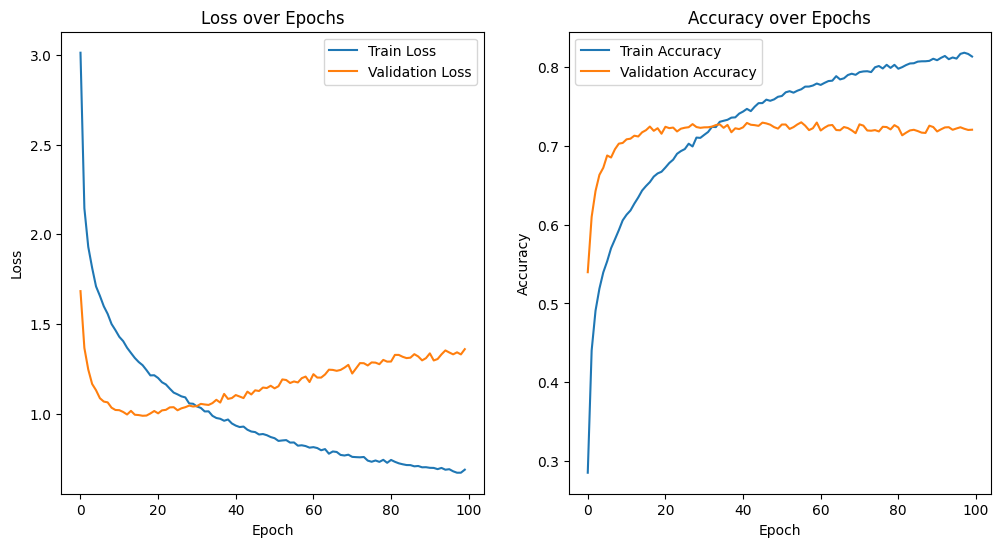

Training with batch_size=128, lr_layer4=5e-05,lr_fc=0.0001
Epoch [1/100], Train Loss: 3.3569, Train Acc: 0.2487, Val Loss: 2.0775, Val Acc: 0.4802
Epoch [2/100], Train Loss: 2.3995, Train Acc: 0.4117, Val Loss: 1.5972, Val Acc: 0.5746
Epoch [3/100], Train Loss: 2.1105, Train Acc: 0.4649, Val Loss: 1.4042, Val Acc: 0.6105
Epoch [4/100], Train Loss: 1.9448, Train Acc: 0.4983, Val Loss: 1.2882, Val Acc: 0.6370
Epoch [5/100], Train Loss: 1.8267, Train Acc: 0.5233, Val Loss: 1.2034, Val Acc: 0.6568
Epoch [6/100], Train Loss: 1.7457, Train Acc: 0.5428, Val Loss: 1.1482, Val Acc: 0.6723
Epoch [7/100], Train Loss: 1.6701, Train Acc: 0.5602, Val Loss: 1.1192, Val Acc: 0.6780
Epoch [8/100], Train Loss: 1.6192, Train Acc: 0.5720, Val Loss: 1.0780, Val Acc: 0.6932
Epoch [9/100], Train Loss: 1.5738, Train Acc: 0.5829, Val Loss: 1.0415, Val Acc: 0.6997
Epoch [10/100], Train Loss: 1.5285, Train Acc: 0.5943, Val Loss: 1.0296, Val Acc: 0.7010
Epoch [11/100], Train Loss: 1.4878, Train Acc: 0.6049, Val L

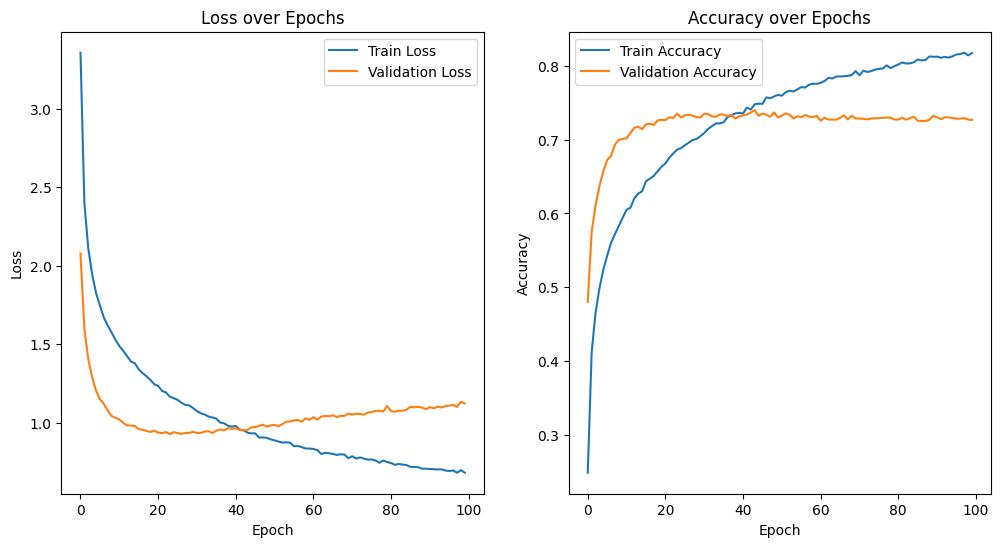

Training with batch_size=128, lr_layer4=1e-05,lr_fc=0.001
Epoch [1/100], Train Loss: 3.1531, Train Acc: 0.2563, Val Loss: 1.8438, Val Acc: 0.4990
Epoch [2/100], Train Loss: 2.3612, Train Acc: 0.3951, Val Loss: 1.5312, Val Acc: 0.5660
Epoch [3/100], Train Loss: 2.1769, Train Acc: 0.4355, Val Loss: 1.4367, Val Acc: 0.5896
Epoch [4/100], Train Loss: 2.0842, Train Acc: 0.4573, Val Loss: 1.3611, Val Acc: 0.6101
Epoch [5/100], Train Loss: 2.0114, Train Acc: 0.4730, Val Loss: 1.3054, Val Acc: 0.6229
Epoch [6/100], Train Loss: 1.9584, Train Acc: 0.4867, Val Loss: 1.2979, Val Acc: 0.6285
Epoch [7/100], Train Loss: 1.9060, Train Acc: 0.4980, Val Loss: 1.2462, Val Acc: 0.6414
Epoch [8/100], Train Loss: 1.8755, Train Acc: 0.5037, Val Loss: 1.2198, Val Acc: 0.6502
Epoch [9/100], Train Loss: 1.8587, Train Acc: 0.5076, Val Loss: 1.2202, Val Acc: 0.6478
Epoch [10/100], Train Loss: 1.8227, Train Acc: 0.5149, Val Loss: 1.2543, Val Acc: 0.6371
Epoch [11/100], Train Loss: 1.7842, Train Acc: 0.5259, Val Lo

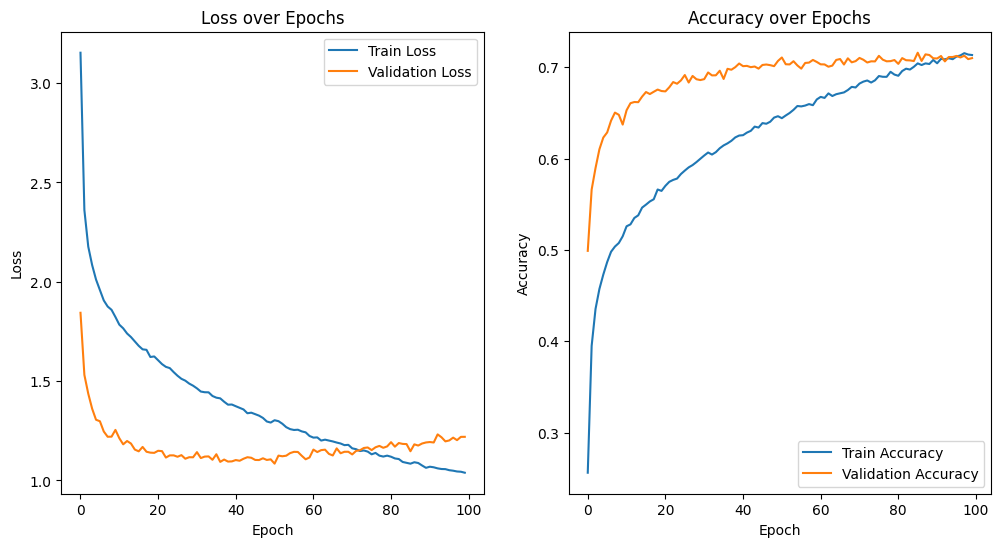

Training with batch_size=128, lr_layer4=1e-05,lr_fc=0.0005
Epoch [1/100], Train Loss: 3.4287, Train Acc: 0.2155, Val Loss: 2.1182, Val Acc: 0.4499
Epoch [2/100], Train Loss: 2.4798, Train Acc: 0.3747, Val Loss: 1.6546, Val Acc: 0.5456
Epoch [3/100], Train Loss: 2.2380, Train Acc: 0.4235, Val Loss: 1.4898, Val Acc: 0.5789
Epoch [4/100], Train Loss: 2.1054, Train Acc: 0.4511, Val Loss: 1.3743, Val Acc: 0.6026
Epoch [5/100], Train Loss: 2.0322, Train Acc: 0.4673, Val Loss: 1.3304, Val Acc: 0.6156
Epoch [6/100], Train Loss: 1.9590, Train Acc: 0.4837, Val Loss: 1.2943, Val Acc: 0.6240
Epoch [7/100], Train Loss: 1.9204, Train Acc: 0.4919, Val Loss: 1.2486, Val Acc: 0.6369
Epoch [8/100], Train Loss: 1.8687, Train Acc: 0.5033, Val Loss: 1.2201, Val Acc: 0.6452
Epoch [9/100], Train Loss: 1.8409, Train Acc: 0.5102, Val Loss: 1.2149, Val Acc: 0.6506
Epoch [10/100], Train Loss: 1.8050, Train Acc: 0.5202, Val Loss: 1.1956, Val Acc: 0.6528
Epoch [11/100], Train Loss: 1.7799, Train Acc: 0.5222, Val L

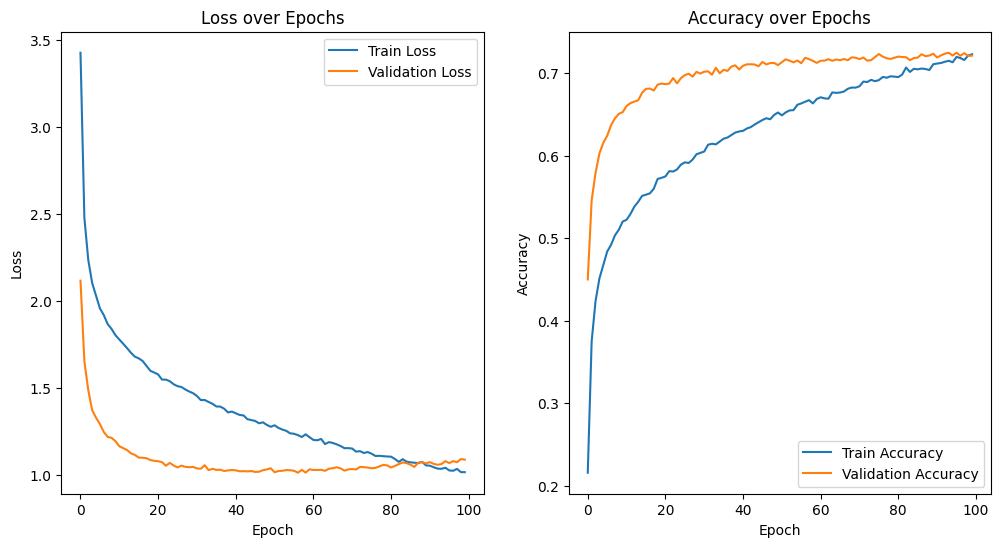

Training with batch_size=128, lr_layer4=1e-05,lr_fc=0.0001
Epoch [1/100], Train Loss: 4.0483, Train Acc: 0.1227, Val Loss: 3.0963, Val Acc: 0.2965
Epoch [2/100], Train Loss: 3.0959, Train Acc: 0.2881, Val Loss: 2.3075, Val Acc: 0.4316
Epoch [3/100], Train Loss: 2.6617, Train Acc: 0.3583, Val Loss: 1.9422, Val Acc: 0.4939
Epoch [4/100], Train Loss: 2.4367, Train Acc: 0.3956, Val Loss: 1.7241, Val Acc: 0.5378
Epoch [5/100], Train Loss: 2.2884, Train Acc: 0.4206, Val Loss: 1.6051, Val Acc: 0.5658
Epoch [6/100], Train Loss: 2.1866, Train Acc: 0.4416, Val Loss: 1.5030, Val Acc: 0.5839
Epoch [7/100], Train Loss: 2.0994, Train Acc: 0.4572, Val Loss: 1.4351, Val Acc: 0.6009
Epoch [8/100], Train Loss: 2.0322, Train Acc: 0.4718, Val Loss: 1.3720, Val Acc: 0.6154
Epoch [9/100], Train Loss: 1.9835, Train Acc: 0.4841, Val Loss: 1.3279, Val Acc: 0.6297
Epoch [10/100], Train Loss: 1.9404, Train Acc: 0.4913, Val Loss: 1.2911, Val Acc: 0.6320
Epoch [11/100], Train Loss: 1.8972, Train Acc: 0.5025, Val L

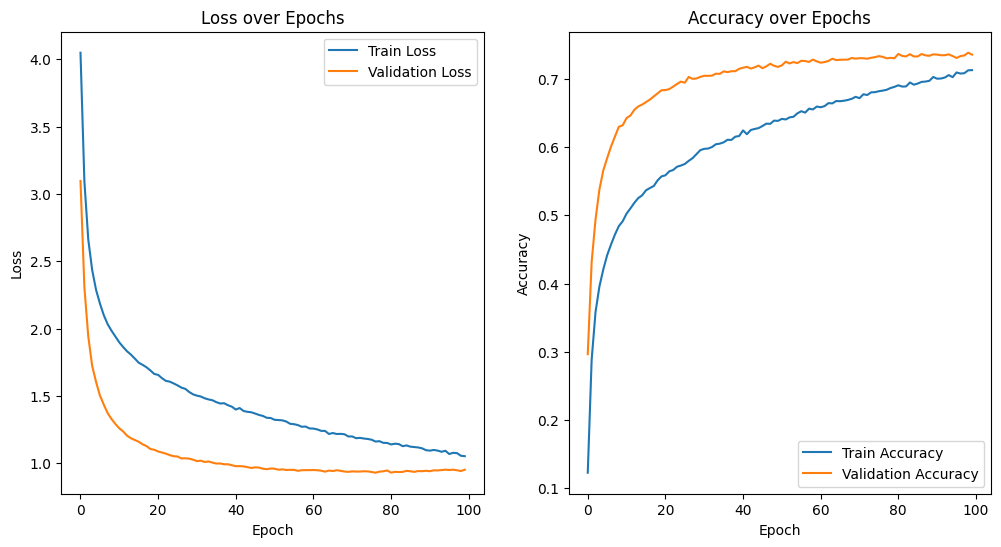

Best Accuracy: 0.7445
Best Parameters: {'batch_size': 32, 'lr_layer4': 1e-05, 'lr_fc': 0.0001}


In [8]:
import csv
from itertools import product
param_grid = {
    'batch_size': [32, 64, 128],
    'lr_layer4': [0.0001, 0.00005, 0.00001],
    'lr_fc':[0.001,0.0005,0.0001]    
}
best_acc = 0.0
best_params = {}
with open('hyperparameter_search_results.csv', 'w', newline='') as csvfile:
    fieldnames = ['batch_size', 'lr_layer4', 'lr_fc', 'accuracy']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for batch_size, lr_layer4,lr_fc in product(*param_grid.values()):
        model.load_state_dict(initial_state)
        print(f'Training with batch_size={batch_size}, lr_layer4={lr_layer4},lr_fc={lr_fc}')
        accuracy = train(model,train_dataset,test_dataset,batch_size=batch_size,layer4_lr=lr_layer4,fc_lr=lr_fc,epoch=100)
        writer.writerow({'batch_size': batch_size, 'lr_layer4': lr_layer4,'lr_fc':lr_fc, 'accuracy': accuracy})
        if accuracy > best_acc:
            best_acc = accuracy
            best_params = {'batch_size': batch_size, 'lr_layer4': lr_layer4,'lr_fc':lr_fc}
with open('best_hyperparameters.txt', 'w') as f:
    f.write(f'Best Accuracy: {best_acc}\n')
    f.write(f'Best Parameters: {best_params}\n')
print(f'Best Accuracy: {best_acc}')
print(f'Best Parameters: {best_params}')

In [1]:
torch.save(model.state_dict,'resnet18_pretrained_model_weights_pre.pth')

NameError: name 'torch' is not defined